In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocesamiento y entrenamiento del modelo

Iniciando el proceso de Ingeniería de Características...
Iniciando extracción de características con ajuste de círculos...
DataFrame con nuevas características creado:
   eventID  n_hits  fit_radius  fit_error      beta
0        0       7   73.705707   1.593809  0.985278
1        1      15   93.617721   1.143896  0.993355
2        2      14   96.202042   1.622691  0.995086
3        3      15  100.208004   1.440074  0.996539
4        4      15   98.654417   0.965629  0.995639

Datos listos para entrenar. Forma de X_train: (79914, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753 (10.75 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 192 (768.00 B)


Iniciando entrenamiento del modelo con características de ajuste de círculo...
Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2105 - r2_score: -6541.9688 - val_loss: 0.0653 - val_r2_score: -2020.5082
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1088 - r2_score: -3344.1345 - val_loss: 0.0290 - val_r2_score: -906.0284
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0571 - r2_score: -1764.4315 - val_loss: 0.0069 - val_r2_score: -218.8586
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0302 - r2_score: -917.6343 - val_loss: 0.0032 - val_r2_score: -96.4687
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0178 - r2_score: -547.6688 - val_loss: 0.0031 - val_r2_score: -91.0033
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0131 - r2_score: -403.4636 - val_loss: 0.0034 - val_r2_score: -100.0002
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0101 - r2_score: -307.5049 - val_loss: 0.0035

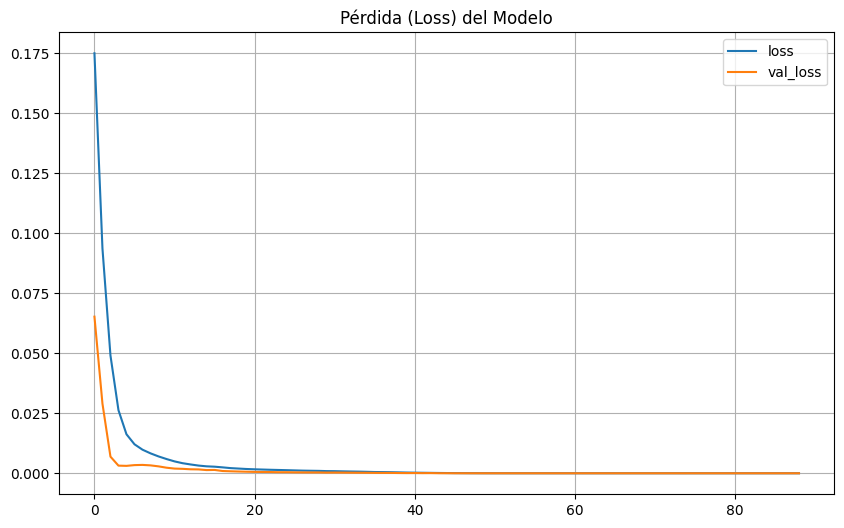

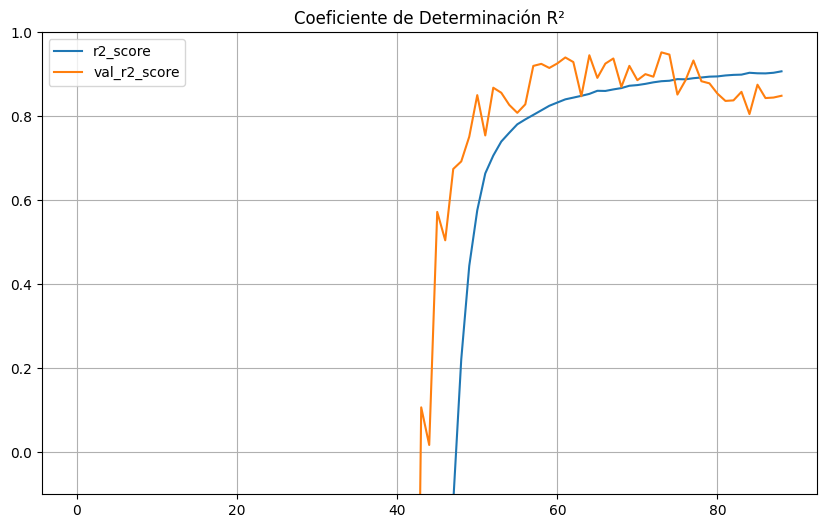

In [ ]:
import os, shutil, math
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D,
                                     Flatten, Dense, BatchNormalization,
                                     Activation, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import math

#Función para calcular beta teórica
M = 938.272           # MeV/c²

def beta(E, m=M):
    γ = 1.0 + E/m
    return math.sqrt(1.0 - 1.0/γ**2)

def cuantizar_hits(x, y, paso=8.5, x0=0.0, y0=0.0, modo="centro"):

    i = np.floor((x - x0) / paso).astype(int)
    j = np.floor((y - y0) / paso).astype(int)

    if modo == "centro":
        xq = x0 + (i + 0.5) * paso
        yq = y0 + (j + 0.5) * paso
    elif modo == "floor":
        xq = x0 + i * paso
        yq = y0 + j * paso
    else:
        raise ValueError("modo debe ser 'centro' o 'floor'")

    return xq, yq

NUM_EVENTOS  = 500_0000      # nº máximo de eventos a cargar
RUTA_CSV     = "/content/drive/MyDrive/datos hits/Prueba.csv"

df_uno = pd.read_csv(RUTA_CSV)

# Convertir a numérico las columnas relevantes (por si hay strings u otros problemas)
cols_to_center = ["x(mm)", "y(mm)"]

# 1️⃣ Asegurar que son numéricas
df_uno[cols_to_center] = df_uno[cols_to_center].apply(pd.to_numeric, errors='coerce')

# 2️⃣ Calcular el centroide (media) por evento
df_uno[["x0(mm)", "y0(mm)"]] = df_uno.groupby("eventID")[cols_to_center].transform("mean")

print("Iniciando el proceso de Ingeniería de Características...")

df_filtrado = df_uno.copy()

# --- NUEVA FUNCIÓN: Ajuste de Círculo por Mínimos Cuadrados ---
def fit_circle_least_squares(x, y):
    """
    Ajusta un círculo a un conjunto de puntos (x, y) usando el método de Kåsa.
    Devuelve el radio del círculo y el error residual promedio.
    """
    if len(x) < 3:
        return 0, 0 # No se puede ajustar un círculo con menos de 3 puntos

    A = np.array([x, y, np.ones(len(x))]).T
    B = x**2 + y**2

    # Resolver el sistema lineal para los coeficientes del círculo
    try:
        C = np.linalg.solve(A.T @ A, A.T @ B)
    except np.linalg.LinAlgError:
        return 0, 0 # Matriz singular, no se puede resolver

    # Extraer el radio y el centro
    xc = C[0] / 2
    yc = C[1] / 2
    radius = np.sqrt(C[2] + xc**2 + yc**2)

    # Calcular el error residual (distancia promedio de los puntos al círculo)
    distances_from_center = np.sqrt((x - xc)**2 + (y - yc)**2)
    residuals = distances_from_center - radius
    fit_error = np.mean(np.abs(residuals))

    return radius, fit_error

print("Iniciando extracción de características con ajuste de círculos...")

features_list = []
energy_col = next(c for c in df_filtrado.columns if "energy" in c.lower())

for event_id, grp in df_filtrado.groupby('eventID'):
    # Extraer coordenadas del evento
    x_coords = grp['x(mm)'].values
    y_coords = grp['y(mm)'].values

    # --- Aplicar el ajuste de círculo ---
    fit_radius, fit_error = fit_circle_least_squares(x_coords, y_coords)

    # Obtener la energía y beta teórica
    energy = grp[energy_col].iloc[0]
    beta_val = beta(energy)

    features_list.append({
        'eventID': event_id,
        'n_hits': len(grp),
        'fit_radius': fit_radius,
        'fit_error': fit_error,
        'beta': beta_val
    })

df_features_fit = pd.DataFrame(features_list).fillna(0)

print("DataFrame con nuevas características creado:")
print(df_features_fit.head())

# Separa las nuevas características (X) y la etiqueta (y)
features = ['n_hits', 'fit_radius', 'fit_error']
target = 'beta'

X = df_features_fit[features]
y = df_features_fit[target]

# Divide y escala los datos como antes
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"\nDatos listos para entrenar. Forma de X_train: {X_train_scaled.shape}")

#Creación del Modelo

# Métrica R² personalizada
def r2_score(y_true, y_pred):
    ss_res = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred))
    ss_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

# Definición del modelo
inp = tf.keras.Input(shape=(len(features),)) # La entrada es un vector de 3 características
x = tf.keras.layers.Dense(64, activation='relu')(inp)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)

# Capa de salida acotada
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
out = tf.keras.layers.Lambda(lambda v: v * 1.2)(x)

model = tf.keras.Model(inp, out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=[r2_score]
)

model.summary()

# Entrenar el modelo
print("\nIniciando entrenamiento del modelo con características de ajuste de círculo...")
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)],
    verbose=1
)

# Graficar resultados
print("\nEntrenamiento finalizado. Mostrando gráficas de rendimiento...")
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.title('Pérdida (Loss) del Modelo')
plt.grid(True)
plt.show()

pd.DataFrame(history.history)[['r2_score', 'val_r2_score']].plot(figsize=(10, 6))
plt.title('Coeficiente de Determinación R²')
plt.ylim(-0.1, 1) # Ajusta el eje Y para ver mejor si R² se vuelve positivo
plt.grid(True)


# Predicción de la Velocidad de Partículas (β) con Redes Neuronales

En este notebook, construiremos un modelo de aprendizaje profundo para predecir la velocidad relativa de una partícula (conocida como $\beta$, beta) basándonos en los datos de los "hits" que deja en un detector.

El proceso se divide en los siguientes pasos:
1.  **Carga y Preprocesamiento de Datos**: Cargaremos los datos de los hits y calcularemos el centroide de cada evento para normalizar las posiciones.
2.  **Ingeniería de Características**: A partir de las coordenadas de los hits de cada evento, extraeremos características significativas como el radio de la trayectoria circular y el error de ajuste.
3.  **Construcción del Modelo**: Definiremos una red neuronal densa (Feedforward) utilizando TensorFlow y Keras.
4.  **Entrenamiento y Evaluación**: Entrenaremos el modelo con los datos procesados y visualizaremos su rendimiento a lo largo del entrenamiento.

---

### 1. Importación de Librerías y Definiciones Iniciales

Primero, importamos todas las librerías necesarias para la manipulación de datos, cálculo numérico, visualización y construcción del modelo de aprendizaje profundo.

| Librería             | Uso Principal                                                              |
| -------------------- | -------------------------------------------------------------------------- |
| `os`, `shutil`       | Interacción con el sistema operativo (no se usan activamente en este fragmento). |
| `math`               | Funciones matemáticas básicas.                                             |
| `numpy`              | Computación numérica y manejo de arrays.                                   |
| `pandas`             | Manipulación y análisis de datos a través de DataFrames.                   |
| `matplotlib.pyplot`  | Creación de gráficos y visualizaciones.                                    |
| `sklearn`            | Herramientas de machine learning para preprocesamiento y división de datos. |
| `tensorflow`         | Plataforma principal para construir y entrenar modelos de deep learning.   |

```python
import os, shutil, math
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D,
                                     Flatten, Dense, BatchNormalization,
                                     Activation, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import math
```

#### Constantes y Funciones Auxiliares

Definimos algunas constantes y funciones que nos serán útiles a lo largo del notebook.

-   **Masa del Protón (`M`)**: Se establece la masa del protón en $MeV/c^2$, que se usará para calcular $\beta$.
-   **Función `beta(E, m)`**: Calcula la velocidad teórica de una partícula ($\beta$) en función de su energía cinética ($E$) y su masa en reposo ($m$). La relación se basa en el factor de Lorentz ($\gamma$):
    $$\gamma = 1 + \frac{E}{m}$$
    $$\beta = \sqrt{1 - \frac{1}{\gamma^2}}$$
-   **Función `cuantizar_hits(...)`**: Aunque está definida, esta función no se utiliza en el flujo principal del código. Su propósito es agrupar las coordenadas de los hits en una grilla discreta (cuantización).

```python
#Función para calcular beta teórica
M = 938.272           # MeV/c²

def beta(E, m=M):
    """Calcula la velocidad teórica (beta) de una partícula a partir de su energía cinética."""
    γ = 1.0 + E/m
    return math.sqrt(1.0 - 1.0/γ**2)

def cuantizar_hits(x, y, paso=8.5, x0=0.0, y0=0.0, modo="centro"):
    """Discretiza las coordenadas (x, y) en una grilla."""
    i = np.floor((x - x0) / paso).astype(int)
    j = np.floor((y - y0) / paso).astype(int)

    if modo == "centro":
        xq = x0 + (i + 0.5) * paso
        yq = y0 + (j + 0.5) * paso
    elif modo == "floor":
        xq = x0 + i * paso
        yq = y0 + j * paso
    else:
        raise ValueError("modo debe ser 'centro' o 'floor'")

    return xq, yq
```

---

### 2. Carga y Preprocesamiento de Datos

Cargamos el conjunto de datos desde un archivo CSV. Cada fila representa un "hit" de una partícula en el detector y contiene información como su posición (`x(mm)`, `y(mm)`) y a qué evento pertenece (`eventID`).

```python
NUM_EVENTOS  = 500_0000      # nº máximo de eventos a cargar (constante informativa)
RUTA_CSV     = "/content/drive/MyDrive/datos hits/Prueba.csv"

df_uno = pd.read_csv(RUTA_CSV)
```

#### Centrado de Coordenadas por Evento

Para que la posición de los hits sea relativa al centro de su propio evento y no a un origen absoluto, calculamos el centroide (la media de las coordenadas `x` e `y`) para cada `eventID`.

1.  **Asegurar tipo numérico**: Convertimos las columnas de coordenadas a un formato numérico, manejando posibles errores.
2.  **Calcular el centroide**: Usando `groupby("eventID")` y `transform("mean")`, creamos dos nuevas columnas, `x0(mm)` y `y0(mm)`, que contienen la coordenada central de cada evento.

```python
# Convertir a numérico las columnas relevantes
cols_to_center = ["x(mm)", "y(mm)"]
df_uno[cols_to_center] = df_uno[cols_to_center].apply(pd.to_numeric, errors='coerce')

# Calcular el centroide (media) por evento
df_uno[["x0(mm)", "y0(mm)"]] = df_uno.groupby("eventID")[cols_to_center].transform("mean")

print("Columnas de centroide añadidas al DataFrame.")
```

---

### 3. Ingeniería de Características

En lugar de usar las coordenadas brutas de los hits, crearemos características más informativas que resuman la geometría de cada evento. La hipótesis es que la trayectoria de los hits se asemeja a un círculo.

#### Función de Ajuste Circular

La función `fit_circle_least_squares` ajusta un círculo a un conjunto de puntos `(x, y)` utilizando el método de mínimos cuadrados (específicamente, el método de Kåsa). Devuelve dos características clave:
1.  **`fit_radius`**: El radio del círculo ajustado.
2.  **`fit_error`**: El error residual promedio, que mide qué tan bien se ajustan los puntos al círculo. Un error bajo indica que los hits forman un arco de círculo casi perfecto.

```python
def fit_circle_least_squares(x, y):
    """
    Ajusta un círculo a un conjunto de puntos (x, y) usando el método de Kåsa.
    Devuelve el radio del círculo y el error residual promedio.
    """
    if len(x) < 3:
        return 0, 0 # No se puede ajustar un círculo con menos de 3 puntos

    A = np.array([x, y, np.ones(len(x))]).T
    B = x**2 + y**2

    # Resolver el sistema lineal para los coeficientes del círculo
    try:
        C = np.linalg.solve(A.T @ A, A.T @ B)
    except np.linalg.LinAlgError:
        return 0, 0 # Matriz singular, no se puede resolver

    # Extraer el radio y el centro
    xc = C[0] / 2
    yc = C[1] / 2
    radius = np.sqrt(C[2] + xc**2 + yc**2)

    # Calcular el error residual
    distances_from_center = np.sqrt((x - xc)**2 + (y - yc)**2)
    residuals = distances_from_center - radius
    fit_error = np.mean(np.abs(residuals))

    return radius, fit_error
```

#### Extracción de Características por Evento

Ahora iteramos sobre cada evento en nuestro `DataFrame`, aplicamos la función de ajuste circular y recopilamos las nuevas características junto con la cantidad de hits y el valor teórico de $\beta$.

```python
print("Iniciando extracción de características con ajuste de círculos...")

features_list = []
# Identificar la columna de energía dinámicamente
energy_col = next(c for c in df_uno.columns if "energy" in c.lower())

for event_id, grp in df_uno.groupby('eventID'):
    # Extraer coordenadas del evento
    x_coords = grp['x(mm)'].values
    y_coords = grp['y(mm)'].values

    # Aplicar el ajuste de círculo
    fit_radius, fit_error = fit_circle_least_squares(x_coords, y_coords)

    # Obtener la energía y beta teórica
    energy = grp[energy_col].iloc[0]
    beta_val = beta(energy)

    features_list.append({
        'eventID': event_id,
        'n_hits': len(grp),
        'fit_radius': fit_radius,
        'fit_error': fit_error,
        'beta': beta_val
    })

# Crear un nuevo DataFrame con las características extraídas
df_features_fit = pd.DataFrame(features_list).fillna(0)

print("DataFrame con nuevas características creado:")
print(df_features_fit.head())
```

---

### 4. Preparación de Datos para el Modelo

Con nuestro nuevo `DataFrame` de características, preparamos los datos para entrenar el modelo.

1.  **Separar Características (X) y Etiqueta (y)**:
    * `X`: Las variables predictoras (`n_hits`, `fit_radius`, `fit_error`).
    * `y`: La variable objetivo que queremos predecir (`beta`).
2.  **Dividir en Entrenamiento y Validación**: Separamos los datos en un conjunto de entrenamiento (para aprender) y uno de validación (para evaluar el rendimiento en datos no vistos).
3.  **Escalar Características**: Estandarizamos las características usando `StandardScaler`. Esto es crucial para que la red neuronal funcione correctamente, ya que asegura que todas las características tengan una media de 0 y una desviación estándar de 1.

```python
# Separa las nuevas características (X) y la etiqueta (y)
features = ['n_hits', 'fit_radius', 'fit_error']
target = 'beta'

X = df_features_fit[features]
y = df_features_fit[target]

# Divide los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Escala las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"\nDatos listos para entrenar. Forma de X_train: {X_train_scaled.shape}")
```

---

### 5. Construcción del Modelo de Red Neuronal

Definimos la arquitectura de nuestra red neuronal usando la API funcional de Keras.

#### Métrica R² Personalizada
El Coeficiente de Determinación ($R^2$) es una métrica común para problemas de regresión que indica qué proporción de la varianza en la variable dependiente es predecible a partir de las variables independientes. Un valor cercano a 1 indica un buen ajuste.
$$R^2 = 1 - \frac{\sum_{i}(y_i - \hat{y}_i)^2}{\sum_{i}(y_i - \bar{y})^2}$$
Como no es una métrica estándar en Keras, la definimos manualmente.

```python
def r2_score(y_true, y_pred):
    """Métrica del Coeficiente de Determinación (R²) para Keras."""
    ss_res = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred))
    ss_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())
```

#### Arquitectura del Modelo
El modelo es una red neuronal densa simple con las siguientes capas:
-   **Input**: Recibe un vector con nuestras 3 características.
-   **Capas Ocultas**: Dos capas `Dense` con activación `ReLU`.
-   **BatchNormalization**: Ayuda a estabilizar y acelerar el entrenamiento.
-   **Dropout**: Técnica de regularización para prevenir el sobreajuste, "apagando" aleatoriamente un 30% de las neuronas en cada paso de entrenamiento.
-   **Capa de Salida**:
    -   Una capa `Dense` con activación `sigmoid`, que produce una salida entre 0 y 1.
    -   Una capa `Lambda` que multiplica la salida por 1.2. Esto ajusta el rango de predicción a $[0, 1.2]$, lo cual puede ser más apropiado para $\beta$, que teóricamente está acotado en $[0, 1)$ pero podría tener predicciones ligeramente superiores.

```python
# Definición del modelo
inp = tf.keras.Input(shape=(len(features),)) # La entrada es un vector de 3 características
x = tf.keras.layers.Dense(64, activation='relu')(inp)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)

# Capa de salida acotada y re-escalada
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
out = tf.keras.layers.Lambda(lambda v: v * 1.2)(x)

model = tf.keras.Model(inp, out)

# Compilación del modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',  # Mean Squared Error (Error Cuadrático Medio)
    metrics=[r2_score]
)

model.summary()
```

---

### 6. Entrenamiento del Modelo

Entrenamos el modelo con los datos de entrenamiento escalados. Usamos un callback de `EarlyStopping` para detener el entrenamiento si la pérdida en el conjunto de validación (`val_loss`) no mejora durante 15 épocas consecutivas. Esto previene el sobreajuste y guarda automáticamente los mejores pesos del modelo.

```python
print("\nIniciando entrenamiento del modelo...")
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)],
    verbose=1
)
```

---

### 7. Visualización de Resultados

Finalmente, graficamos el historial de entrenamiento para evaluar el rendimiento del modelo.

#### Gráfica de Pérdida (Loss)
Esta gráfica muestra cómo el error del modelo (MSE) disminuye tanto en los datos de entrenamiento como en los de validación. Idealmente, ambas curvas deben converger. Una gran brecha entre ellas indicaría sobreajuste.

```python
print("\nEntrenamiento finalizado. Mostrando gráficas de rendimiento...")
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.title('Pérdida (Loss) del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.grid(True)
plt.show()
```

#### Gráfica del Coeficiente de Determinación (R²)
Esta gráfica muestra cómo la métrica $R^2$ mejora a lo largo de las épocas. Valores más cercanos a 1 indican que el modelo explica mejor la variabilidad de los datos.

```python
pd.DataFrame(history.history)[['r2_score', 'val_r2_score']].plot(figsize=(10, 6))
plt.title('Coeficiente de Determinación R²')
plt.xlabel('Épocas')
plt.ylabel('R² Score')
plt.ylim(-0.1, 1) # Ajusta el eje Y para ver mejor el rendimiento
plt.grid(True)
plt.show()
```

## Guarda el modelo

In [ ]:
 import pickle
 model.save("betanet_v5.h5")
 with open('data_scaler.pkl', 'wb') as f:
     pickle.dump(scaler, f)

## Carga los dataframes de los 5 eventos nuevos y gráfica su primer evento

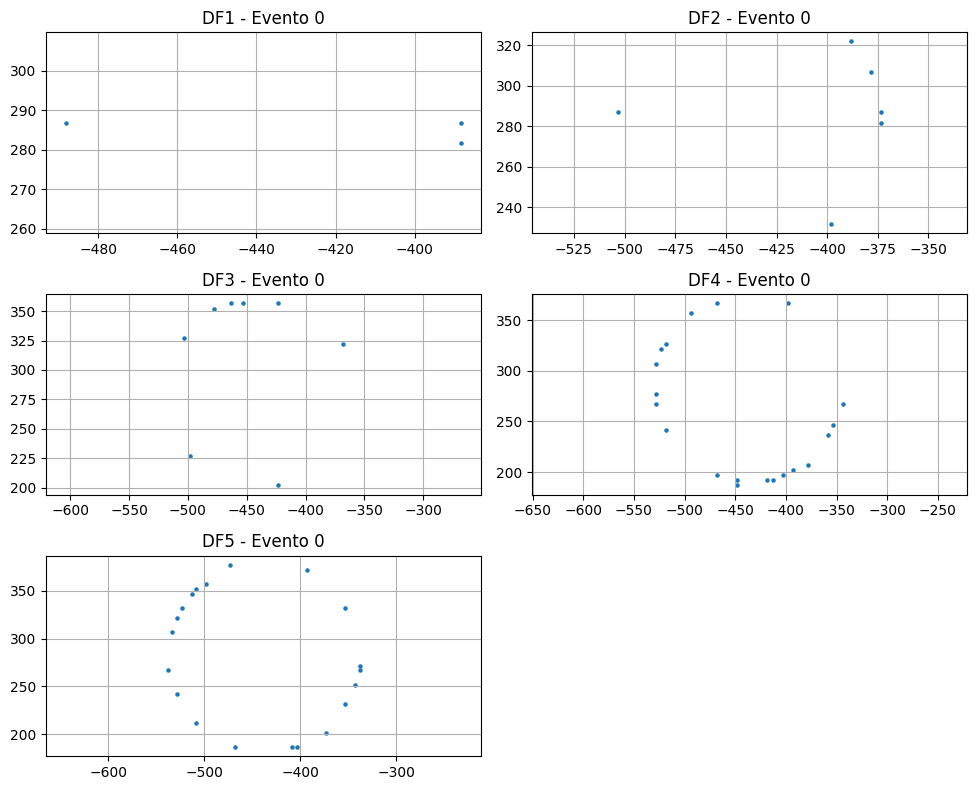

In [ ]:
# Rutas
RUTA_CSV1 = "/content/drive/MyDrive/datos hits/PP3_5.csv"
RUTA_CSV2 = "/content/drive/MyDrive/datos hits/PP4.csv"
RUTA_CSV3 = "/content/drive/MyDrive/datos hits/PP5.csv"
RUTA_CSV4 = "/content/drive/MyDrive/datos hits/PP7.csv"
RUTA_CSV5 = "/content/drive/MyDrive/datos hits/PP10.csv"

# Cargar primeros 500 hits de cada archivo
df1 = pd.read_csv(RUTA_CSV1).head(50000)
df2 = pd.read_csv(RUTA_CSV2).head(50000)
df3 = pd.read_csv(RUTA_CSV3).head(50000)
df4 = pd.read_csv(RUTA_CSV4).head(50000)
df5 = pd.read_csv(RUTA_CSV5).head(50000)

dataframes = [df1, df2, df3, df4, df5]

df_centered_list = dataframes

# Graficar un evento por DataFrame
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
axes = axes.flatten()
titles = ['DF1', 'DF2', 'DF3', 'DF4', 'DF5']

for i, df_centered in enumerate(df_centered_list):
    ax = axes[i]
    # Elegir el primer evento del DataFrame
    first_event = df_centered['eventID'].unique()[0]
    df_event = df_centered[df_centered['eventID'] == first_event]
    ax.scatter(df_event["x(mm)"], df_event["y(mm)"], s=5)
    ax.set_title(f"{titles[i]} - Evento {first_event}")
    ax.axis('equal')
    ax.grid(True)

# Si hay más subplots que DataFrames, oculta el sobrante
for j in range(len(df_centered_list), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
df_filtrados = df_centered_list

## Gráfica las predicciones del modelo y un evento individual


Cargando el modelo y el escalador guardados...
❌ Error: Asegúrate de que los archivos 'betanet.h5' y 'data_scaler.pkl' están en la misma carpeta.

===== Procesando y prediciendo para DataFrame #1 =====
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
✅ Prediciones guardadas para el DataFrame #1.

===== Procesando y prediciendo para DataFrame #2 =====
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
✅ Prediciones guardadas para el DataFrame #2.

===== Procesando y prediciendo para DataFrame #3 =====
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
✅ Prediciones guardadas para el DataFrame #3.

===== Procesando y prediciendo para DataFrame #4 =====
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
✅ Prediciones guardadas para el DataFrame #4.

===== Procesando y prediciendo para DataFrame #5 =====
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
✅ Prediciones guardadas para el DataFrame #5.


🎉 Todas las predicciones han sido generadas y guardadas.


📊 ===== Iniciando Análisis Individual por Energía =====

--- Análisis para Ene

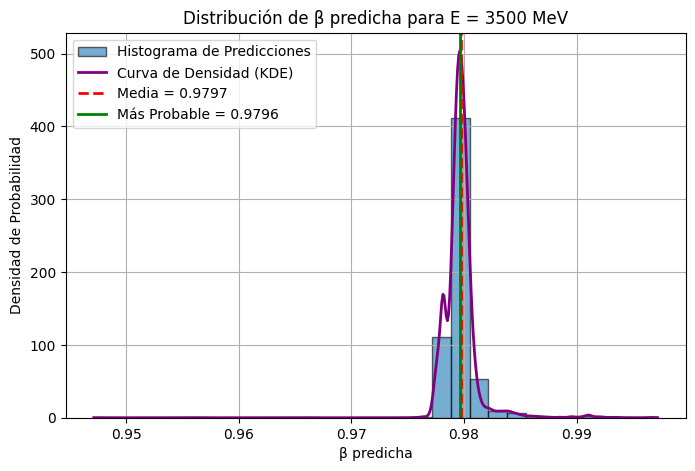


--- Análisis para Energía = 4000 MeV ---
  - Media de β_pred:              0.983208
  - Valor Más Probable (Moda):    0.983085
Análisis para E=4000 MeV: Beta Teórica=0.9818, Media Predicha=0.9832
Análisis para E=4000 MeV: Beta Teórica=0.9818, Moda Predicha=0.9831


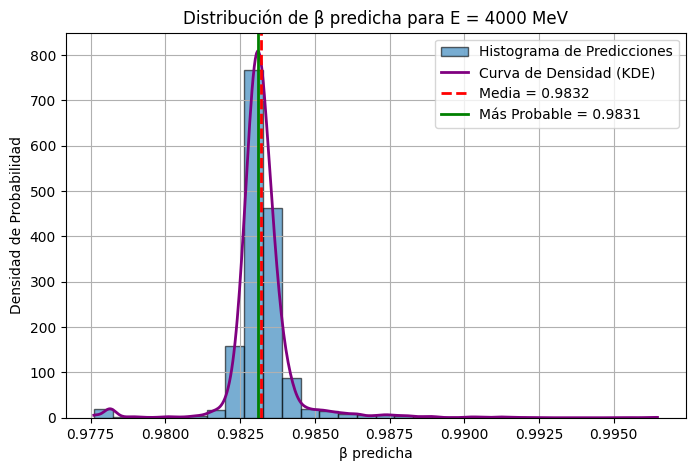


--- Análisis para Energía = 5000 MeV ---
  - Media de β_pred:              0.988325
  - Valor Más Probable (Moda):    0.988381
Análisis para E=5000 MeV: Beta Teórica=0.9874, Media Predicha=0.9883
Análisis para E=5000 MeV: Beta Teórica=0.9874, Moda Predicha=0.9884


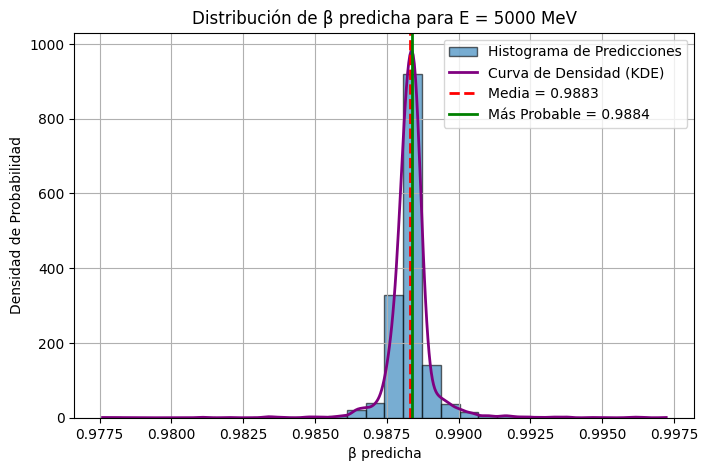


--- Análisis para Energía = 7000 MeV ---
  - Media de β_pred:              0.993320
  - Valor Más Probable (Moda):    0.993336
Análisis para E=7000 MeV: Beta Teórica=0.9930, Media Predicha=0.9933
Análisis para E=7000 MeV: Beta Teórica=0.9930, Moda Predicha=0.9933


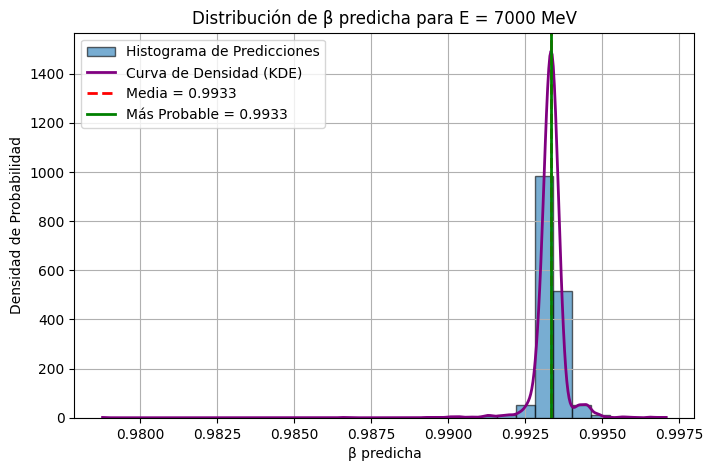


--- Análisis para Energía = 10000 MeV ---
  - Media de β_pred:              0.995910
  - Valor Más Probable (Moda):    0.995982
Análisis para E=10000 MeV: Beta Teórica=0.9963, Media Predicha=0.9959
Análisis para E=10000 MeV: Beta Teórica=0.9963, Moda Predicha=0.9960


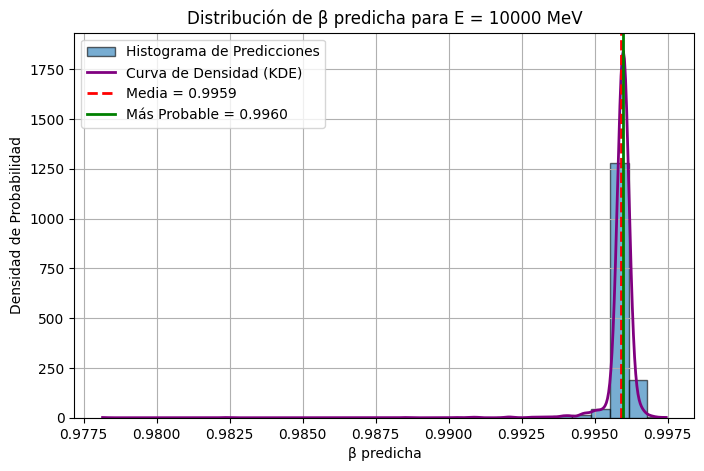



📈 ===== Generando Gráficas de Correlación Finales =====


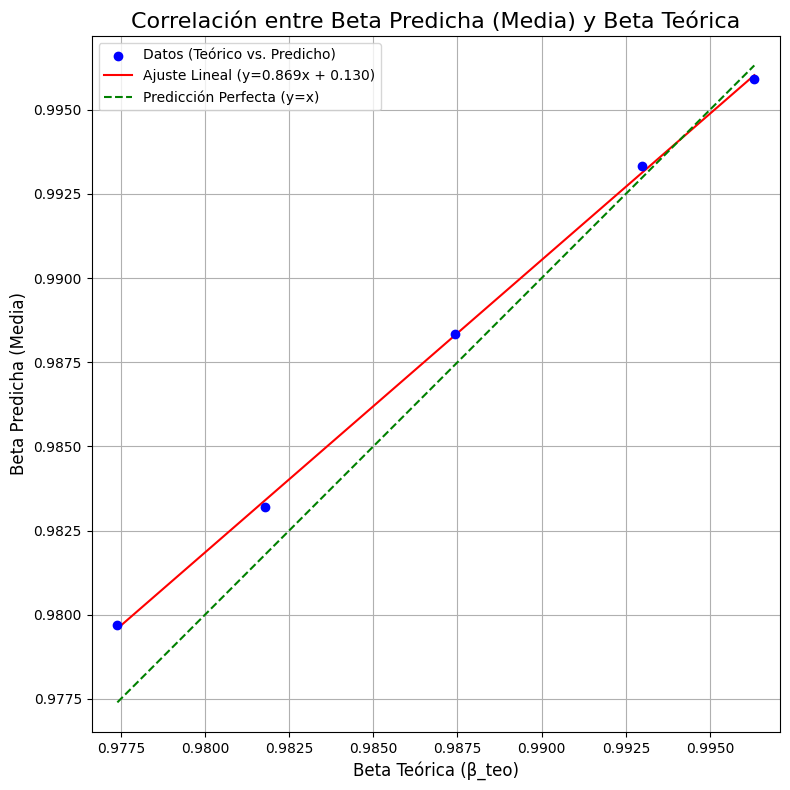

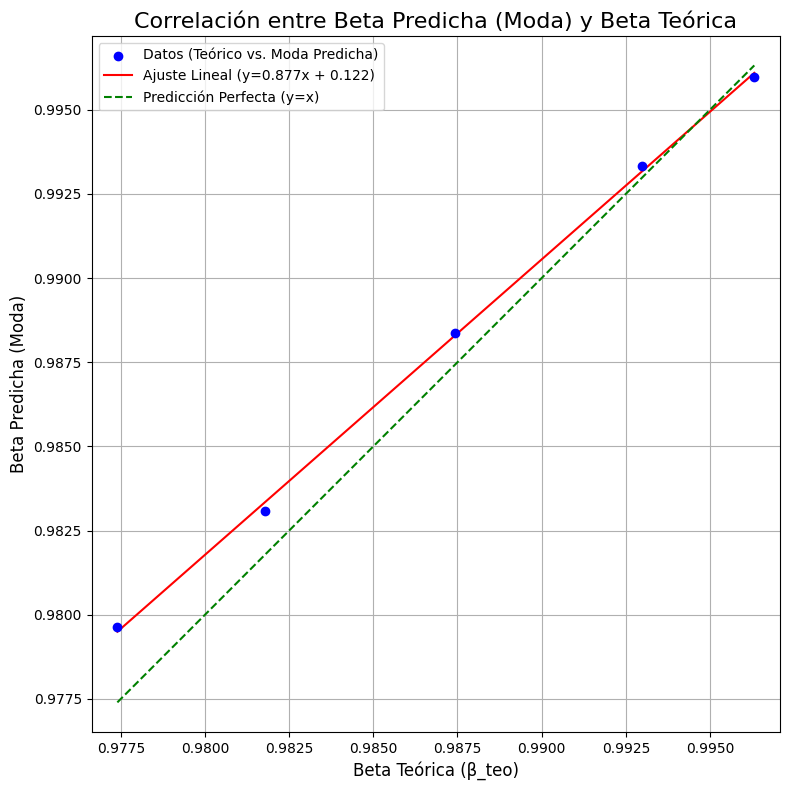

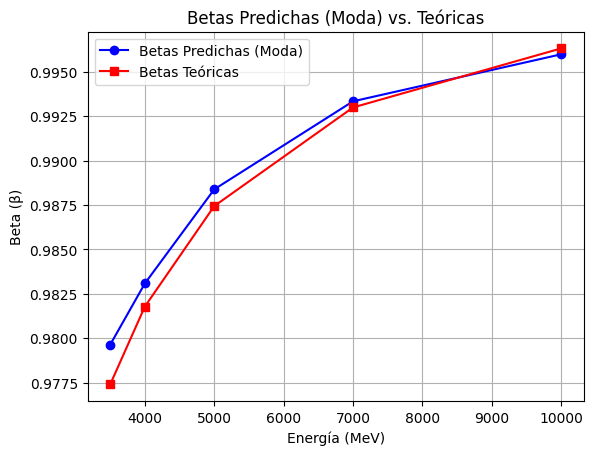



🖼️  --- Creando gráficas para eventos individuales ---


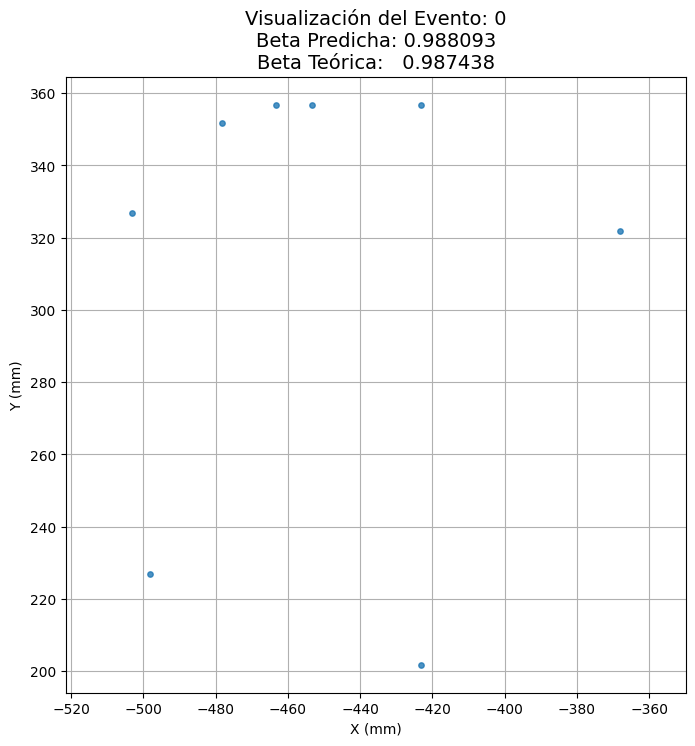

Centro del evento para graficar anillo: (-405.6426, 312.7163)


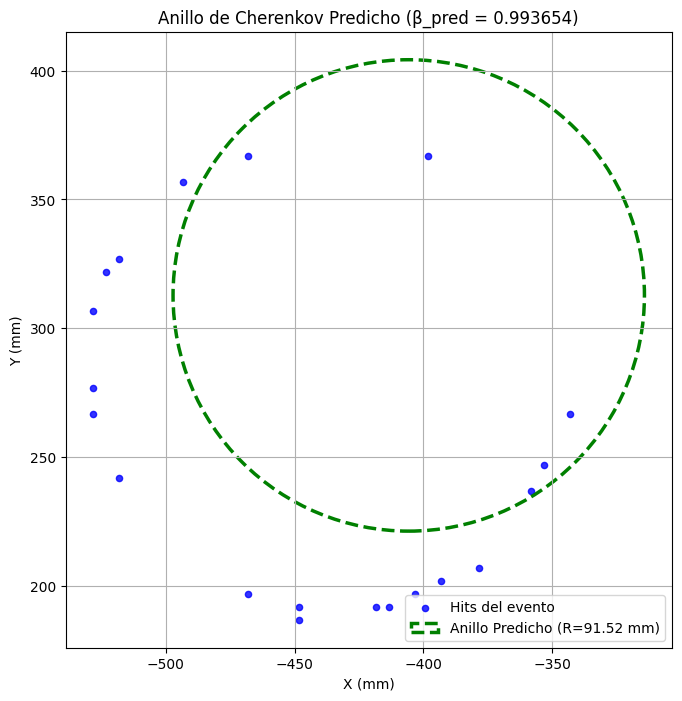

El radio del anillo predicho para este evento es: 91.52 mm


In [ ]:
from scipy.stats import gaussian_kde

def graficar_anillo_beta_pred(puntos, beta_pred, n=1.03, D=420, centro=(0,0), color="green"):
    """
    Grafica el anillo de Cherenkov usando la beta predicha por el modelo.
    """
    if beta_pred * n <= 1:
        print(f"⚠️ No hay radiación de Cherenkov para la beta predicha (β*n = {beta_pred * n:.3f} <= 1)")
        return

    # Ángulo Cherenkov
    theta_c = np.arccos(1.0 / (beta_pred * n))
    # Radio teórico
    R = D * np.tan(theta_c)

    # Graficar
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect("equal")

    puntos = np.array(puntos)
    ax.scatter(puntos[:,0], puntos[:,1], color="blue", s=20, alpha=0.8, label="Hits del evento")

    circle_pred = plt.Circle(centro, R, fill=False, color=color, linewidth=2.5, linestyle='--',
                             label=f"Anillo Predicho (R={R:.2f} mm)")
    ax.add_patch(circle_pred)

    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")
    ax.set_title(f"Anillo de Cherenkov Predicho (β_pred = {beta_pred:.6f})")
    ax.legend()
    plt.grid(True)
    plt.show()

    return R

#Carga el Modelo y el Escalador
print("Cargando el modelo y el escalador guardados...")
try:
    model = tf.keras.models.load_model(
        "betanet.h5",
        custom_objects={'r2_score': r2_score},
        safe_mode=False
    )
    with open('data_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    print("✅ Modelo y escalador cargados correctamente.")
except FileNotFoundError:
    print("❌ Error: Asegúrate de que los archivos 'betanet.h5' y 'data_scaler.pkl' están en la misma carpeta.")
    exit()


#PREDICCIÓN Y ALMACENAMIENTO

all_predictions = []  # Para el análisis global
results_list = []     # Para la visualización de eventos individuales

for i, df_individual_centered in enumerate(df_centered_list):
    print(f"\n===== Procesando y prediciendo para DataFrame #{i+1} =====")

    features_list = []
    for event_id, grp in df_individual_centered.groupby('eventID'):
        x_coords = grp['x(mm)'].values
        y_coords = grp['y(mm)'].values
        fit_radius, fit_error = fit_circle_least_squares(x_coords, y_coords)
        features_list.append({
            'eventID': event_id, 'n_hits': len(grp),
            'fit_radius': fit_radius, 'fit_error': fit_error,
        })
    df_features = pd.DataFrame(features_list).fillna(0)

    if df_features.empty:
        print("No se encontraron eventos. Saltando al siguiente DataFrame.")
        all_predictions.append(np.array([]))
        results_list.append(pd.DataFrame())
        continue

    features_cols = ['n_hits', 'fit_radius', 'fit_error']
    X_new_scaled = scaler.transform(df_features[features_cols])
    predicted_betas = model.predict(X_new_scaled)

    # Guardar predicciones en ambas estructuras de datos
    flat_predictions = predicted_betas.flatten()
    all_predictions.append(flat_predictions)

    df_features['beta_predicha'] = predicted_betas
    results_list.append(df_features)

    print(f"✅ Prediciones guardadas para el DataFrame #{i+1}.")

print("\n\n🎉 Todas las predicciones han sido generadas y guardadas.")

#  ANÁLISIS POR ENERGÍA Y VISUALIZACIÓN DE DISTRIBUCIONES

E = [3500, 4000, 5000, 7000, 10000]
mean_predicted_betas = []
mode_predicted_betas = []
betas_teo_list = []

print("\n\n📊 ===== Iniciando Análisis Individual por Energía =====")
for k, beta_preds in enumerate(all_predictions):
    if len(beta_preds) == 0:
        print(f"\n--- No hay datos para Energía con índice {k} (E={E[k]} MeV). Saltando. ---")
        continue

    print(f"\n--- Análisis para Energía = {E[k]} MeV ---")

    # a) Cálculo de la media y el valor más probable (moda)
    beta_mean = beta_preds.mean()
    kde = gaussian_kde(beta_preds)
    x_grid = np.linspace(beta_preds.min(), beta_preds.max(), 500)
    kde_values = kde(x_grid)
    beta_mode = x_grid[np.argmax(kde_values)]
    beta_teo = beta(E[k])

    # b) Impresión de resultados en consola (como en tu código original)
    print(f"  - Media de β_pred:              {beta_mean:.6f}")
    print(f"  - Valor Más Probable (Moda):    {beta_mode:.6f}")
    # Esta línea se toma de tus bucles posteriores para tener toda la info junta
    print(f"Análisis para E={E[k]} MeV: Beta Teórica={beta_teo:.4f}, Media Predicha={beta_mean:.4f}")
    print(f"Análisis para E={E[k]} MeV: Beta Teórica={beta_teo:.4f}, Moda Predicha={beta_mode:.4f}")

    # c) Guardar valores para las gráficas finales
    mean_predicted_betas.append(beta_mean)
    mode_predicted_betas.append(beta_mode)
    betas_teo_list.append(beta_teo)

    # d) Graficar la distribución
    plt.figure(figsize=(8, 5))
    plt.hist(beta_preds, bins=30, edgecolor='k', alpha=0.6, density=True, label='Histograma de Predicciones')
    plt.plot(x_grid, kde_values, color='purple', linewidth=2, label='Curva de Densidad (KDE)')
    plt.axvline(beta_mean, color='red', linestyle='--', linewidth=2, label=f'Media = {beta_mean:.4f}')
    plt.axvline(beta_mode, color='green', linestyle='-', linewidth=2, label=f'Más Probable = {beta_mode:.4f}')
    plt.xlabel('β predicha')
    plt.ylabel('Densidad de Probabilidad')
    plt.title(f'Distribución de β predicha para E = {E[k]} MeV')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Gráfica de Correlación con la MEDIA ---
betas_teo_np = np.array(betas_teo_list)
beta_means_np = np.array(mean_predicted_betas)
m, b = np.polyfit(betas_teo_np, beta_means_np, 1)

plt.figure(figsize=(8, 8))
plt.scatter(betas_teo_np, beta_means_np, color='blue', label='Datos (Teórico vs. Predicho)', zorder=5)
plt.plot(betas_teo_np, m * betas_teo_np + b, color='red', linestyle='-', label=f'Ajuste Lineal (y={m:.3f}x + {b:.3f})')
plt.plot(betas_teo_np, betas_teo_np, color='green', linestyle='--', label='Predicción Perfecta (y=x)')
plt.title('Correlación entre Beta Predicha (Media) y Beta Teórica', fontsize=16)
plt.xlabel('Beta Teórica (β_teo)', fontsize=12)
plt.ylabel('Beta Predicha (Media)', fontsize=12)
plt.legend(); plt.grid(True); plt.axis('equal'); plt.tight_layout(); plt.show()

# --- Gráfica de Correlación con la MODA ---
beta_modes_np = np.array(mode_predicted_betas)
m, b = np.polyfit(betas_teo_np, beta_modes_np, 1)

plt.figure(figsize=(8, 8))
plt.scatter(betas_teo_np, beta_modes_np, color='blue', label='Datos (Teórico vs. Moda Predicha)', zorder=5)
plt.plot(betas_teo_np, m * betas_teo_np + b, color='red', linestyle='-', label=f'Ajuste Lineal (y={m:.3f}x + {b:.3f})')
plt.plot(betas_teo_np, betas_teo_np, color='green', linestyle='--', label='Predicción Perfecta (y=x)')
plt.title('Correlación entre Beta Predicha (Moda) y Beta Teórica', fontsize=16)
plt.xlabel('Beta Teórica (β_teo)', fontsize=12)
plt.ylabel('Beta Predicha (Moda)', fontsize=12)
plt.legend(); plt.grid(True); plt.axis('equal'); plt.tight_layout(); plt.show()

# --- Gráfica de Evolución vs Energía ---
plt.plot(E, beta_modes_np, marker='o', linestyle='-', color='blue', label='Betas Predichas (Moda)')
plt.plot(E, betas_teo_np, marker='s', linestyle='-', color='red', label='Betas Teóricas')
plt.title('Betas Predichas (Moda) vs. Teóricas')
plt.xlabel('Energía (MeV)'); plt.ylabel('Beta (β)')
plt.legend(); plt.grid(True); plt.show()

# --- Visualización del evento en el índice 2 ---
df_source_hits = df_centered_list[2]
df_source_results = results_list[2]
if not df_source_results.empty:
    event_id_to_plot = df_source_results['eventID'].iloc[0]
    event_hits = df_source_hits[df_source_hits['eventID'] == event_id_to_plot]
    predicted_beta = df_source_results[df_source_results['eventID'] == event_id_to_plot]['beta_predicha'].iloc[0]
    energy_col = next(c for c in event_hits.columns if "energy" in c.lower())
    event_energy = event_hits[energy_col].iloc[0]
    theoretical_beta = beta(event_energy)

    plt.figure(figsize=(8, 8))
    plt.scatter(event_hits["x(mm)"], event_hits["y(mm)"], s=15, alpha=0.8)
    plt.title(
        f"Visualización del Evento: {event_id_to_plot}\n"
        f"Beta Predicha: {predicted_beta:.6f}\n"
        f"Beta Teórica:   {theoretical_beta:.6f}",
        fontsize=14
    )
    plt.xlabel("X (mm)"); plt.ylabel("Y (mm)")
    plt.grid(True); plt.axis('equal'); plt.show()
else:
    print("No hay eventos en el DataFrame con índice 2 para graficar.")

# --- Visualización del evento con anillo en el índice 3 ---
df_source_hits = df_centered_list[3]
df_source_results = results_list[3]
if not df_source_results.empty:
    event_id_to_plot = df_source_results['eventID'].iloc[0]
    event_hits = df_source_hits[df_source_hits['eventID'] == event_id_to_plot]
    puntos_del_evento = event_hits[['x(mm)', 'y(mm)']].to_numpy()
    predicted_beta = df_source_results[df_source_results['eventID'] == event_id_to_plot]['beta_predicha'].iloc[0]

    # Obtener el centro del evento para la función de graficado
    xo = df_source_hits['x0(mm)'].iloc[0]
    yo = df_source_hits['y0(mm)'].iloc[0]
    centro_evento = (xo, yo)

    print(f"Centro del evento para graficar anillo: ({xo}, {yo})")


    radio_predicho = graficar_anillo_beta_pred(puntos_del_evento, predicted_beta, centro=centro_evento)
    if radio_predicho is not None:
        print(f"El radio del anillo predicho para este evento es: {radio_predicho:.2f} mm")
else:
    print("No hay eventos en el DataFrame con índice 3 para graficar.")

# Análisis y Visualización de Predicciones de Beta (β)

Este notebook utiliza el modelo de red neuronal previamente entrenado y guardado para realizar predicciones sobre nuevos conjuntos de datos. El flujo de trabajo se centra en:

1.  **Cargar el Modelo**: Se carga el modelo `betanet.h5` y el escalador de datos `data_scaler.pkl`.
2.  **Realizar Predicciones**: Se procesan nuevos eventos, se extraen sus características y se utiliza el modelo para predecir el valor de $\beta$.
3.  **Análisis Estadístico**: Se analizan las distribuciones de las $\beta$ predichas para diferentes niveles de energía.
4.  **Visualización de Resultados**: Se generan gráficos para evaluar el rendimiento del modelo, incluyendo correlaciones, distribuciones y la visualización de eventos individuales con su anillo de Cherenkov predicho.

---

### 1. Función de Visualización del Anillo de Cherenkov

Para interpretar visualmente la predicción de $\beta$ para un evento específico, creamos una función que dibuja el anillo de Cherenkov correspondiente.

-   **Principio Físico**: La radiación Cherenkov se produce cuando una partícula viaja a una velocidad ($\beta c$) mayor que la velocidad de la luz en ese medio ($c/n$). El ángulo de emisión de esta luz, $\theta_c$, depende de $\beta$ y del índice de refracción $n$.
$$\theta_c = \arccos\left(\frac{1}{\beta \cdot n}\right)$$
Este cono de luz proyecta un anillo en un detector plano a una distancia $D$, con un radio $R$:
$$R = D \cdot \tan(\theta_c)$$
-   **La función `graficar_anillo_beta_pred`**:
    1.  Recibe los puntos (*hits*) de un evento y el valor de $\beta$ predicho por el modelo.
    2.  Calcula el radio teórico $R$ del anillo de Cherenkov.
    3.  Grafica los *hits* originales y superpone un círculo discontinuo que representa el anillo predicho.

```python
from scipy.stats import gaussian_kde

def graficar_anillo_beta_pred(puntos, beta_pred, n=1.03, D=420, centro=(0,0), color="green"):
    """
    Grafica el anillo de Cherenkov usando la beta predicha por el modelo.
    """
    if beta_pred * n <= 1:
        print(f"⚠️ No hay radiación de Cherenkov para la beta predicha (β*n = {beta_pred * n:.3f} <= 1)")
        return

    # Ángulo Cherenkov
    theta_c = np.arccos(1.0 / (beta_pred * n))
    # Radio teórico
    R = D * np.tan(theta_c)

    # Graficar
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect("equal")

    puntos = np.array(puntos)
    ax.scatter(puntos[:,0], puntos[:,1], color="blue", s=20, alpha=0.8, label="Hits del evento")

    circle_pred = plt.Circle(centro, R, fill=False, color=color, linewidth=2.5, linestyle='--',
                             label=f"Anillo Predicho (R={R:.2f} mm)")
    ax.add_patch(circle_pred)

    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")
    ax.set_title(f"Anillo de Cherenkov Predicho (β_pred = {beta_pred:.6f})")
    ax.legend()
    plt.grid(True)
    plt.show()

    return R
```

---

### 2. Carga del Modelo y Escalador

Antes de hacer predicciones, es fundamental cargar el modelo entrenado y el objeto `StandardScaler` que se utilizó durante el entrenamiento.

-   **`tf.keras.models.load_model`**: Carga el archivo `betanet.h5`. Es crucial incluir `custom_objects={'r2_score': r2_score}` porque `r2_score` era una métrica personalizada.
-   **`pickle.load`**: Carga el escalador desde `data_scaler.pkl`. **Esto es vital**, ya que los nuevos datos deben ser escalados exactamente de la misma manera que los datos de entrenamiento para que las predicciones sean válidas.

---

### 3. Proceso de Predicción en Lote

Este bloque itera a través de una lista de DataFrames (`df_centered_list`), donde cada DataFrame contiene eventos de una energía específica. Para cada DataFrame:
1.  **Ingeniería de Características**: Se aplica la misma función `fit_circle_least_squares` a cada evento para calcular `n_hits`, `fit_radius` y `fit_error`.
2.  **Escalado**: Las características extraídas se transforman utilizando el `scaler` cargado.
3.  **Predicción**: El método `model.predict()` se invoca sobre los datos escalados para obtener los valores de $\beta$.
4.  **Almacenamiento**: Las predicciones se guardan en dos listas: `all_predictions` para análisis estadístico global y `results_list` para inspección individual de eventos.


### 4. Análisis por Energía y Visualización de Distribuciones

Una vez realizadas todas las predicciones, analizamos los resultados para cada nivel de energía. Para cada conjunto de predicciones:

1.  **Cálculo de Estadísticos**:
    -   Se calcula la **media** de las $\beta$ predichas.
    -   Se estima el **valor más probable (moda)** utilizando una Estimación de Densidad Kernel (KDE), que proporciona una visión más suave de la distribución que un simple histograma.
2.  **Visualización de la Distribución**:
    -   Se genera un histograma de las $\beta$ predichas.
    -   Se superpone la curva KDE, la media y la moda para visualizar la tendencia central y la dispersión de las predicciones.


---

### 5. Análisis de Correlación y Evolución

Para evaluar el rendimiento general del modelo, se realizan tres gráficos clave:

1.  **Correlación (Media y Moda vs. Teórica)**: Se crean gráficos de dispersión que comparan la $\beta$ teórica con la media y la moda de las $\beta$ predichas para cada nivel de energía. Se añade una línea de "predicción perfecta" (y=x) y un ajuste lineal. Un buen modelo mostrará puntos cercanos a la línea y=x.
2.  **Evolución con la Energía**: Se grafica cómo cambian la $\beta$ teórica y la $\beta$ predicha (moda) en función de la energía. Esto verifica si el modelo captura correctamente la tendencia física esperada.

---

### 6. Visualización de Eventos Individuales

Finalmente, para obtener una comprensión cualitativa de los resultados, seleccionamos eventos específicos y los visualizamos.

1.  **Visualización de Hits**: Se elige un evento y se grafica la dispersión de sus *hits*. El título del gráfico compara directamente la $\beta$ predicha por el modelo con el valor teórico real, permitiendo una rápida verificación visual.
2.  **Visualización con Anillo Predicho**: Se selecciona otro evento y se utiliza la función `graficar_anillo_beta_pred` para superponer el anillo de Cherenkov correspondiente a la $\beta$ predicha. Esto cierra el ciclo, conectando la salida numérica del modelo con su interpretación física y geométrica.

